# Howard Cloud Classify MONAI Pytorch

## Install MONAI

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

#print_config()

## Read image filenames from the dataset folders

In [3]:
train_dir='../input/howard-cloudx/Howard-Cloud-X/train'
test_dir='../input/howard-cloudx/Howard-Cloud-X/test'

In [4]:
#train
class_names0 = os.listdir(train_dir)
print(class_names0)
class_names = sorted(class_names0)
print(class_names)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

['Cirroculumulus', 'Stratus', 'Stratocumulus', 'Cumulonimbus', 'Altostratus', 'Cirrostratus', 'Nimbostratus', 'Cumulus', 'Cirrus', 'Altocumulus']
['Altocumulus', 'Altostratus', 'Cirroculumulus', 'Cirrostratus', 'Cirrus', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']


In [5]:
valid_frac = 0.3
trainX,trainY = [],[]
valX,valY = [],[]

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX))

841 330


In [6]:
#test
t_class_names0 = os.listdir(test_dir)
t_class_names = sorted(t_class_names0)
print(t_class_names)
t_num_class = len(t_class_names)
t_image_files = [[os.path.join(test_dir, t_class_name, x) 
               for x in os.listdir(os.path.join(test_dir, t_class_name))] 
               for t_class_name in t_class_names]

t_image_file_list = []
t_image_label_list = []
for i, class_name in enumerate(t_class_names):
    t_image_file_list.extend(t_image_files[i])
    t_image_label_list.extend([i] * len(t_image_files[i]))
      

['Altocumulus', 'Altostratus', 'Cirroculumulus', 'Cirrostratus', 'Cirrus', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']


## Visualise some examples

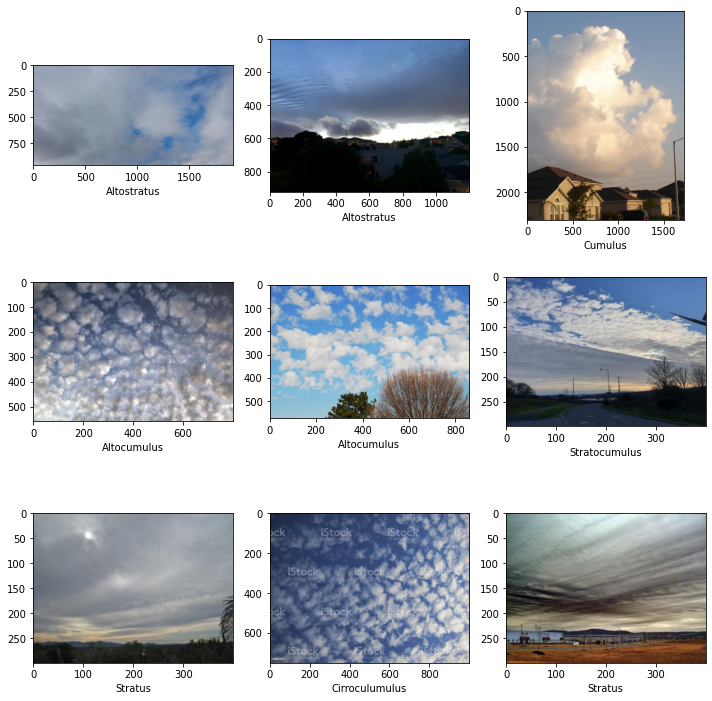

In [7]:
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    #print(arr.shape)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()
# image size and number of channels differ each other

## Prepare training, validation and test data lists

In [8]:
trainX=np.array(trainX)
trainY=np.array(trainY)
valX=np.array(valX)
valY=np.array(valY)
testX=np.array(t_image_file_list)
testY=np.array(t_image_label_list)

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [9]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

In [10]:
class MyResize(Transform):
    def __init__(self, size=(400,300)):
        self.size = size
    def __call__(self, inputs):
        image=cv2.resize(np.array(inputs),dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        image2=image[75:225,100:300]
        return image2

In [11]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class, n_classes=num_class)

In [12]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [13]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

In [14]:
device = torch.device("cpu")   #"cuda:0"
model = DenseNet121(
    spatial_dims=2,            
    in_channels=1,
    out_channels=num_class,
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 80
val_interval = 1

In [15]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())     ##### 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images.float())], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


----------
epoch 1/80
1/26, train_loss: 2.3530
2/26, train_loss: 2.3616
3/26, train_loss: 2.2987
4/26, train_loss: 2.3444
5/26, train_loss: 2.3349
6/26, train_loss: 2.3379
7/26, train_loss: 2.3530
8/26, train_loss: 2.3458
9/26, train_loss: 2.3070
10/26, train_loss: 2.3306
11/26, train_loss: 2.2520
12/26, train_loss: 2.2836
13/26, train_loss: 2.2344
14/26, train_loss: 2.3155
15/26, train_loss: 2.2974
16/26, train_loss: 2.3411
17/26, train_loss: 2.2441
18/26, train_loss: 2.2889
19/26, train_loss: 2.3251
20/26, train_loss: 2.3134
21/26, train_loss: 2.2687
22/26, train_loss: 2.3160
23/26, train_loss: 2.2478
24/26, train_loss: 2.2744
25/26, train_loss: 2.3264
26/26, train_loss: 2.2453
27/26, train_loss: 2.2868
epoch 1 average loss: 2.3047
saved new best metric model
current epoch: 1 current AUC: 0.5611 current accuracy: 0.1424 best AUC: 0.1424 at epoch: 1
----------
epoch 2/80
1/26, train_loss: 2.3111
2/26, train_loss: 2.2647
3/26, train_loss: 2.2204
4/26, train_loss: 2.3345
5/26, train_los

## Plot the loss and metric

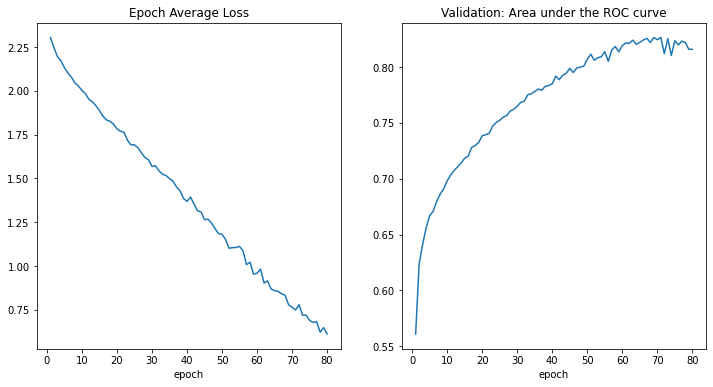

In [16]:
plt.figure('train', (12,6))
plt.subplot(1,2,1)
plt.title("Epoch Average Loss")
x = [i+1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1,2,2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i+1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x,y)
plt.show()

In [17]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
t_y_pred = list()
t_y_true= list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images.float()).argmax(dim=1)
        for i in range(len(pred)):
            t_y_pred.append(pred[i].item())
            t_y_true.append(test_labels[i].item())

In [18]:
print(classification_report(t_y_true, t_y_pred, target_names=class_names, digits=4))

                precision    recall  f1-score   support

   Altocumulus     0.3333    0.3200    0.3265        25
   Altostratus     0.5714    0.8000    0.6667        25
Cirroculumulus     0.4500    0.3600    0.4000        25
  Cirrostratus     0.4211    0.3200    0.3636        25
        Cirrus     0.3684    0.2800    0.3182        25
  Cumulonimbus     0.3125    0.4000    0.3509        25
       Cumulus     0.5161    0.6400    0.5714        25
  Nimbostratus     0.4167    0.4000    0.4082        25
 Stratocumulus     0.2222    0.1600    0.1860        25
       Stratus     0.3214    0.3600    0.3396        25

      accuracy                         0.4040       250
     macro avg     0.3933    0.4040    0.3931       250
  weighted avg     0.3933    0.4040    0.3931       250

